In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/MLMI ISIC'    #project folder directory

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd 'gdrive/My Drive/MLMI ISIC'

/content/gdrive/.shortcut-targets-by-id/1--pR4lc28XpXYYVCqJYiRv3-LG5N4r-t/MLMI ISIC


In [3]:
!pip install pytorch-lightning
!pip install efficientnet-pytorch
!pip install albumentations==0.4.6

     |████████████████████████████████| 317kB 2.8MB/s 
     |████████████████████████████████| 276kB 8.7MB/s 
     |████████████████████████████████| 829kB 12.3MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=d3a322007e5896a2a615127088a24e5df2fd6a239eef2ca387e4627f9f92d674
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=c2a6958c7b9cd87edde38340373c1a084c984c4d18e41a6999fc3b0259fd74fc
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAML future
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
  Created wheel for efficientnet-py

In [4]:
%reload_ext autoreload
%autoreload 2
import os
import torch
import time

import pytorch_lightning as pl
import warnings

warnings.filterwarnings("ignore") 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [5]:
from pytorch_lightning import Trainer, seed_everything

seed_everything(42)

42

In [6]:
import numpy as np
import networkx as nx
import math
import random
from scipy.stats import loguniform

In [7]:

batch_size = {
    'tpu': 64, # x8
    'gpu': 64, # 10 without AMP
    'cpu': 4,
}

In [8]:
num_workers = 2  # os.cpu_count()
gpus = 1 if torch.cuda.is_available() else None

if isinstance(batch_size, dict):
    if gpus:
        batch_size = batch_size['gpu']
    else:
        batch_size = batch_size['cpu']

#lr *= batch_size 

In [9]:
batch_size

64

In [ ]:
import os

list = os.listdir('compressedISIC/512x512-dataset-melanoma/512x512-dataset-melanoma/') # dir is your directory path
number_files = len(list)
print(number_files)

60487


In [10]:
from models.ISIC2020Net import ISIC2020Net
import gc

In [ ]:
class Graph:

    def __init__(self,num_lr,num_wd):
      self.num_lr = num_lr
      self.num_wd = num_wd
    
    def generate_graph(self):
      G = nx.DiGraph()        #Directional graph
      edges=[]
      G.add_node('inp')
      G.add_node('out')
      
      np.random.seed(42)

      rvs_lr = loguniform.rvs(1e-6, 1e-2, size=self.num_lr)
      for lr in range(self.num_lr):
        #learning_rate = random.uniform(1e-5, 1e-2)
        G.add_node(lr, lr=rvs_lr[lr])
        edge = ['inp',lr,1]                     #initial weight is 1 (pheromone value)
        edges.append(edge)

      np.random.seed(42)
      
      rvs_wd = loguniform.rvs(1e-5, 1e-3, size=self.num_wd)
      for wd in range(self.num_wd):
       #weight_decay = random.uniform(1e-5, 1e-3)
       G.add_node(wd+self.num_lr, wd = rvs_wd[wd])
       edge = [wd+self.num_lr,'out',1]
       edges.append(edge)
       for lr in range(self.num_lr):
         edge = [lr,wd+self.num_lr,1]
         edges.append(edge)  

      G.add_weighted_edges_from(edges)
    
      return G

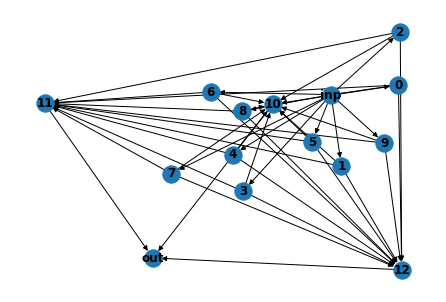

In [ ]:
Graphed = Graph(10,3)
G = Graphed.generate_graph()
nx.draw(G,with_labels=True,font_weight='bold')

In [ ]:
list(G.nodes.data())

[('inp', {}),
 ('out', {}),
 (0, {'lr': 3.14891164795686e-05}),
 (1, {'lr': 0.006351221010640693}),
 (2, {'lr': 0.0008471801418819973}),
 (3, {'lr': 0.000248104097486781}),
 (4, {'lr': 4.2079886696066345e-06}),
 (5, {'lr': 4.207053950287935e-06}),
 (6, {'lr': 1.7073967431528116e-06}),
 (7, {'lr': 0.0029154431891537523}),
 (8, {'lr': 0.0002537815508265663}),
 (9, {'lr': 0.0006796578090758152}),
 (10, {'wd': 5.611516415334504e-05}),
 (11, {'wd': 0.0007969454818643929}),
 (12, {'wd': 0.0002910635913133069})]

In [ ]:
class ACO:

    def __init__(self, num_ants, Graph, batch_size):
         self.num_ants = num_ants
         self.G = Graph
         self.batch_size = batch_size

    def generate_ants(self): 
         best_path = []
         best_auc = 0.0
         paths = []
         for i in range(self.num_ants):
             np.random.seed()         #remove seed, while finding aco path
             path = self.select_aco_path()
             self.local_pheromone_update(path)
             print(path)
             paths.append(path)   
             val_auc = self.evaluation(path) 
             if (val_auc > best_auc):
              best_path = path
              best_auc = val_auc

         print("Group of ants have traversed")
         print(paths)                                                 #all paths traveled by ants of a group
         self.global_pheromone_update(paths,best_path,best_auc)

         result = {
             "best_path": best_path,
             "best_val_auc": best_auc
         }
         return result

    def select_aco_path(self):
        """Selects ant path from source to destination based on ACO select rule"""
        ant_path = []
        current_node = 'inp' 
        ant_path.append(current_node)
        next_node = 'inp'

        while(next_node!='out'):
         next_node = self.aco_select_rule(current_node)
         current_node = next_node
         ant_path.append(next_node)
        
        return ant_path    

    def aco_select_rule(self, current_node):
        """Selects neigbour using ACO transition rule"""
        

        probabilities = []
        denominator = 0.0
        greediness = 0.5
        neighbours = list(G.successors(current_node))
        # Calculate probability for each neighbour    (heuristics are not considered)
        for i in range(len(neighbours)):
            probability = self.G[current_node][neighbours[i]]['weight']    #pheromone value
            probabilities.append(probability)
            denominator += probability
        
        
        # Try to perform greedy select: exploitation
        random_variable = random.uniform(0, 1)
        if random_variable <= greediness:
            # Find max probability
            max_probability = max(probabilities)
            # Gather the indices of probabilities that are equal to the max probability
            max_indices = [i for i, j in enumerate(probabilities) if j == max_probability]
            # From those max indices select random index
            neighbour_index = random.choice(max_indices)
            return neighbours[neighbour_index]

       # Otherwise perform select using roulette wheel: exploration
        probabilities = [x / denominator for x in probabilities]
        probability_sum = sum(probabilities)
        random_threshold = random.uniform(0, probability_sum)
        current_value = 0
        for neighbour_index, probability in enumerate(probabilities):
            current_value += probability
            if current_value > random_threshold:
                return neighbours[neighbour_index]

    def local_pheromone_update(self,path):      
        pheromone_0 = 0.1
        decay = 0.1
        for i in range(len(path)-1):
          self.G[path[i]][path[i+1]]['weight'] = (1 - decay) * self.G[path[i]][path[i+1]]['weight'] + (decay * pheromone_0)

    def global_pheromone_update(self, paths, best_path, best_auc):
        evaporation = 0.1
        added_pheromone = best_auc    #best auc score
        for i in range(self.num_ants):
          if(best_path != paths[i]):       # evaporate weights, if not the best path
             for k in range(len(paths[i])-1):
               self.G[paths[i][k]][paths[i][k+1]]['weight'] = (1 - evaporation) * self.G[paths[i][k]][paths[i][k+1]]['weight']

        for i in range(len(best_path)-1):     # deposit pheromone for the best path only
          self.G[best_path[i]][best_path[i+1]]['weight'] = (1 - evaporation) * self.G[best_path[i]][best_path[i+1]]['weight'] + (evaporation * added_pheromone)


    def evaluation(self,path):
       lr = G.nodes[path[1]]['lr']
       wd = G.nodes[path[2]]['wd']
       hparams = { "fold_number": 4,
                   "label_smoothing": 0.1,
                   "pos_weight": 3.1,
                   "num_workers": 2,
                   "lr": lr,
                   "wd": wd,
                   "batch_size": self.batch_size
                }
       print('lr ',lr)
       print('wd ',wd)

       #temporary results                               # These are validation accuracy and auc for the paths found with 1 epoch
       temp_results = {
                       "['inp', 3, 11, 'out']": [0.758134126663208,0.8784],
                       "['inp', 6, 12, 'out']": [0.7642762660980225,0.8269],
                       "['inp', 3, 12, 'out']": [0.820634126663208,0.8815],
                       "['inp', 7, 10, 'out']": [0.9100266098976135,0.6725],
                       "['inp', 8, 11, 'out']": [0.8992364406585693,0.8609],
                       "['inp', 1, 12, 'out']": [0.883134126663208,0.7890],
                       "['inp', 5, 11, 'out']": [0.8705179691314697,0.8605],
                       "['inp', 8, 10, 'out']": [0.7590471506118774,0.8748],
                       "['inp', 0, 12, 'out']": [0.8917663097381592,0.8904],
                       "['inp', 1, 10, 'out']": [0.9093625545501709,0.7539],
                       "['inp', 2, 11, 'out']": [0.8367364406585693,0.8307],
                       "['inp', 4, 12, 'out']": [0.843625545501709,0.8594],
                       "['inp', 7, 11, 'out']": [0.8800631165504456,0.8191],
                       "['inp', 4, 10, 'out']": [0.8305943012237549,0.8523],
                       "['inp', 9, 12, 'out']": [0.854332685470581,0.8517],
                       "['inp', 8, 12, 'out']": [0.8791500926017761,0.8732]
                      }
       val_acc = 0               
       val_auc = 0
       for key, value in temp_results.items():
          if key == str(path):
            val_acc=value[0]
            val_auc=value[1]

       if(val_auc == 0):     
        model = ISIC2020Net(hparams)
        model.prepare_data()
  
        checkpoint_callback = pl.callbacks.ModelCheckpoint("{epoch:02d}_{val_auc:.4f}",
                                                   save_top_k=1, monitor='val_auc', mode='max')
        gpus = 1 if torch.cuda.is_available() else None
        trainer = pl.Trainer(
                         gpus=gpus,
                         max_epochs=1,
                         num_sanity_val_steps=1,# if debug else 0,
                         checkpoint_callback=checkpoint_callback,
                         deterministic=True
                )
        torch.cuda.empty_cache(); gc.collect()
        torch.cuda.empty_cache(); gc.collect()
        trainer.fit(model)
        val_auc = trainer.checkpoint_callback.best
        val_auc = val_auc.item()
       print('val_auc ',val_auc)
       return val_auc

In [ ]:
num_of_ants = 7
acs=ACO(num_of_ants,G,batch_size)

result_first_group = acs.generate_ants()
print(result_first_group)

['inp', 3, 11, 'out']
lr  0.000248104097486781
wd  0.0007969454818643929
val_auc  0.8784
['inp', 6, 12, 'out']
lr  1.7073967431528116e-06
wd  0.0002910635913133069
val_auc  0.8269
['inp', 3, 12, 'out']
lr  0.000248104097486781
wd  0.0002910635913133069
val_auc  0.8815
['inp', 7, 10, 'out']
lr  0.0029154431891537523
wd  5.611516415334504e-05
val_auc  0.6725
['inp', 8, 11, 'out']
lr  0.0002537815508265663
wd  0.0007969454818643929
val_auc  0.8609
['inp', 1, 12, 'out']
lr  0.006351221010640693
wd  0.0002910635913133069
val_auc  0.789
['inp', 5, 11, 'out']
lr  4.207053950287935e-06
wd  0.0007969454818643929
val_auc  0.8605
Group of ants have traversed
[['inp', 3, 11, 'out'], ['inp', 6, 12, 'out'], ['inp', 3, 12, 'out'], ['inp', 7, 10, 'out'], ['inp', 8, 11, 'out'], ['inp', 1, 12, 'out'], ['inp', 5, 11, 'out']]
{'best_path': ['inp', 3, 12, 'out'], 'best_val_auc': 0.8815}


In [ ]:
 list(G.edges.data())

[('inp', 0, {'weight': 1}),
 ('inp', 1, {'weight': 0.8190000000000001}),
 ('inp', 2, {'weight': 1}),
 ('inp', 3, {'weight': 0.7596400000000001}),
 ('inp', 4, {'weight': 1}),
 ('inp', 5, {'weight': 0.8190000000000001}),
 ('inp', 6, {'weight': 0.8190000000000001}),
 ('inp', 7, {'weight': 0.8190000000000001}),
 ('inp', 8, {'weight': 0.8190000000000001}),
 ('inp', 9, {'weight': 1}),
 (0, 10, {'weight': 1}),
 (0, 11, {'weight': 1}),
 (0, 12, {'weight': 1}),
 (1, 10, {'weight': 1}),
 (1, 11, {'weight': 1}),
 (1, 12, {'weight': 0.8190000000000001}),
 (2, 10, {'weight': 1}),
 (2, 11, {'weight': 1}),
 (2, 12, {'weight': 1}),
 (3, 10, {'weight': 1}),
 (3, 11, {'weight': 0.8190000000000001}),
 (3, 12, {'weight': 0.9071500000000001}),
 (4, 10, {'weight': 1}),
 (4, 11, {'weight': 1}),
 (4, 12, {'weight': 1}),
 (5, 10, {'weight': 1}),
 (5, 11, {'weight': 0.8190000000000001}),
 (5, 12, {'weight': 1}),
 (6, 10, {'weight': 1}),
 (6, 11, {'weight': 1}),
 (6, 12, {'weight': 0.8190000000000001}),
 (7, 10,

In [ ]:
result_second_group = acs.generate_ants()
print(result_second_group)

['inp', 0, 12, 'out']
lr  3.14891164795686e-05
wd  0.0002910635913133069
val_auc  0.8904
['inp', 4, 10, 'out']
lr  4.2079886696066345e-06
wd  5.611516415334504e-05


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name | Type     | Params
----------------------------------
0 | net  | DenseNet | 6 M   


Epoch 0 acc:0.828125 auc:0.4006696343421936
48439


Epoch 0 acc:0.8305943012237549 auc:0.8522756099700928

val_auc  0.8522756099700928
['inp', 2, 11, 'out']
lr  0.0008471801418819973
wd  0.0007969454818643929
val_auc  0.8307
['inp', 9, 12, 'out']
lr  0.0006796578090758152
wd  0.0002910635913133069


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name | Type     | Params
----------------------------------
0 | net  | DenseNet | 6 M   


Epoch 0 acc:0.125 auc:0.4955357313156128
48439


Epoch 0 acc:0.854332685470581 auc:0.8517037034034729

val_auc  0.8517037034034729
['inp', 3, 12, 'out']
lr  0.000248104097486781
wd  0.0002910635913133069
val_auc  0.8815
['inp', 7, 11, 'out']
lr  0.0029154431891537523
wd  0.0007969454818643929
val_auc  0.8191
['inp', 8, 12, 'out']
lr  0.0002537815508265663
wd  0.0002910635913133069


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name | Type     | Params
----------------------------------
0 | net  | DenseNet | 6 M   


Epoch 0 acc:0.125 auc:0.6294642686843872
48439


Epoch 0 acc:0.8791500926017761 auc:0.8732044100761414

val_auc  0.8732044100761414
Group of ants have traversed
[['inp', 0, 12, 'out'], ['inp', 4, 10, 'out'], ['inp', 2, 11, 'out'], ['inp', 9, 12, 'out'], ['inp', 3, 12, 'out'], ['inp', 7, 11, 'out'], ['inp', 8, 12, 'out']]
{'best_path': ['inp', 0, 12, 'out'], 'best_val_auc': 0.8904}


In [ ]:
list(G.edges.data())

[('inp', 0, {'weight': 0.9080400000000001}),
 ('inp', 1, {'weight': 0.8190000000000001}),
 ('inp', 2, {'weight': 0.8190000000000001}),
 ('inp', 3, {'weight': 0.6243084000000001}),
 ('inp', 4, {'weight': 0.8190000000000001}),
 ('inp', 5, {'weight': 0.8190000000000001}),
 ('inp', 6, {'weight': 0.8190000000000001}),
 ('inp', 7, {'weight': 0.6723900000000002}),
 ('inp', 8, {'weight': 0.6723900000000002}),
 ('inp', 9, {'weight': 0.8190000000000001}),
 (0, 10, {'weight': 1}),
 (0, 11, {'weight': 1}),
 (0, 12, {'weight': 0.9080400000000001}),
 (1, 10, {'weight': 1}),
 (1, 11, {'weight': 1}),
 (1, 12, {'weight': 0.8190000000000001}),
 (2, 10, {'weight': 1}),
 (2, 11, {'weight': 0.8190000000000001}),
 (2, 12, {'weight': 1}),
 (3, 10, {'weight': 1}),
 (3, 11, {'weight': 0.8190000000000001}),
 (3, 12, {'weight': 0.7437915000000002}),
 (4, 10, {'weight': 0.8190000000000001}),
 (4, 11, {'weight': 1}),
 (4, 12, {'weight': 1}),
 (5, 10, {'weight': 1}),
 (5, 11, {'weight': 0.8190000000000001}),
 (5, 1

In [ ]:
result_third_group = acs.generate_ants()
print(result_third_group)

['inp', 0, 12, 'out']
lr  3.14891164795686e-05
wd  0.0002910635913133069
val_auc  0.8904
['inp', 3, 12, 'out']
lr  0.000248104097486781
wd  0.0002910635913133069
val_auc  0.8815
['inp', 6, 10, 'out']
lr  1.7073967431528116e-06
wd  5.611516415334504e-05


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name | Type     | Params
----------------------------------
0 | net  | DenseNet | 6 M   


Epoch 0 acc:0.671875 auc:0.6852678656578064
48439


Epoch 0 acc:0.7878486514091492 auc:0.840111255645752

val_auc  0.840111255645752
['inp', 8, 10, 'out']
lr  0.0002537815508265663
wd  5.611516415334504e-05
val_auc  0.8748
['inp', 0, 11, 'out']
lr  3.14891164795686e-05
wd  0.0007969454818643929


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name | Type     | Params
----------------------------------
0 | net  | DenseNet | 6 M   


Epoch 0 acc:0.125 auc:0.3616071343421936
48439


Epoch 0 acc:0.8723439574241638 auc:0.8942416906356812

val_auc  0.8942416906356812
['inp', 5, 12, 'out']
lr  4.207053950287935e-06
wd  0.0002910635913133069


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name | Type     | Params
----------------------------------
0 | net  | DenseNet | 6 M   


Epoch 0 acc:0.171875 auc:0.408482164144516
48439


Epoch 0 acc:0.8567397594451904 auc:0.8563869595527649

val_auc  0.8563869595527649
['inp', 8, 10, 'out']
lr  0.0002537815508265663
wd  5.611516415334504e-05
val_auc  0.8748
Group of ants have traversed
[['inp', 0, 12, 'out'], ['inp', 3, 12, 'out'], ['inp', 6, 10, 'out'], ['inp', 8, 10, 'out'], ['inp', 0, 11, 'out'], ['inp', 5, 12, 'out'], ['inp', 8, 10, 'out']]
{'best_path': ['inp', 0, 11, 'out'], 'best_val_auc': 0.8942416906356812}


In [ ]:
list(G.edges.data())

[('inp', 0, {'weight': 0.7005792130635682}),
 ('inp', 1, {'weight': 0.8190000000000001}),
 ('inp', 2, {'weight': 0.8190000000000001}),
 ('inp', 3, {'weight': 0.5146898040000001}),
 ('inp', 4, {'weight': 0.8190000000000001}),
 ('inp', 5, {'weight': 0.6723900000000002}),
 ('inp', 6, {'weight': 0.6723900000000002}),
 ('inp', 7, {'weight': 0.6723900000000002}),
 ('inp', 8, {'weight': 0.4565450790000001}),
 ('inp', 9, {'weight': 0.8190000000000001}),
 (0, 10, {'weight': 1}),
 (0, 11, {'weight': 0.9084241690635682}),
 (0, 12, {'weight': 0.7445124000000001}),
 (1, 10, {'weight': 1}),
 (1, 11, {'weight': 1}),
 (1, 12, {'weight': 0.8190000000000001}),
 (2, 10, {'weight': 1}),
 (2, 11, {'weight': 0.8190000000000001}),
 (2, 12, {'weight': 1}),
 (3, 10, {'weight': 1}),
 (3, 11, {'weight': 0.8190000000000001}),
 (3, 12, {'weight': 0.6114711150000002}),
 (4, 10, {'weight': 0.8190000000000001}),
 (4, 11, {'weight': 1}),
 (4, 12, {'weight': 1}),
 (5, 10, {'weight': 1}),
 (5, 11, {'weight': 0.819000000

In [ ]:
print(result_first_group)
print(result_second_group)
print(result_third_group)

{'best_path': ['inp', 3, 12, 'out'], 'best_val_auc': 0.8815}
{'best_path': ['inp', 0, 12, 'out'], 'best_val_auc': 0.8904}
{'best_path': ['inp', 0, 11, 'out'], 'best_val_auc': 0.8942}


In [ ]:
for key, value in result_first_group.items():
 if key == 'best_val_auc':
   max_best_auc = max(value,result_second_group[key],result_third_group[key])

if(result_first_group['best_val_auc']==max_best_auc):
   overall_best_path = result_first_group['best_path']

elif(result_second_group['best_val_auc']==max_best_auc):
   overall_best_path = result_second_group['best_path']   

elif(result_third_group['best_val_auc']==max_best_auc):
   overall_best_path = result_third_group['best_path']   

print("Best path among the groups")
print(overall_best_path)
print("Best Learning rate")
print(G.nodes[overall_best_path[1]]['lr'])
print("Best weight decay")
print(G.nodes[overall_best_path[2]]['wd'])
print("Best validation AUC")
print(max_best_auc)

Best path among the groups
['inp', 0, 11, 'out']
Best Learning rate
3.14891164795686e-05
Best weight decay
0.0007969454818643929
Best validation AUC
0.8942


In [13]:
hparams = { "fold_number": 4,
                   "label_smoothing": 0.1,
                   "pos_weight": 3.1,
                   "num_workers": 2,
                   "lr": G.nodes[overall_best_path[1]]['lr'],
                   "wd": G.nodes[overall_best_path[2]]['wd'],
                   "batch_size": 64
          }
model = ISIC2020Net(hparams)   #.load_from_checkpoint('epoch=03_val_auc=0.9134.ckpt')
model.prepare_data()
  
checkpoint_callback = pl.callbacks.ModelCheckpoint("{epoch:02d}_{val_auc:.4f}",
                                                   save_top_k=1, monitor='val_auc', mode='max')
gpus = 1 if torch.cuda.is_available() else None
trainer = pl.Trainer(
                         gpus=gpus,
                         max_epochs=7,
                         num_sanity_val_steps=1,# if debug else 0,
                         checkpoint_callback=checkpoint_callback,
                         deterministic=True
                )
torch.cuda.empty_cache(); gc.collect()
torch.cuda.empty_cache(); gc.collect()
trainer.fit(model)
val_auc = trainer.checkpoint_callback.best
val_auc = val_auc.item()
print('val_auc ',val_auc)  

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name | Type     | Params
----------------------------------
0 | net  | DenseNet | 6 M   


Epoch 0 acc:0.828125 auc:0.4006696343421936
48439


Epoch 0 acc:0.8793160915374756 auc:0.8856398463249207


Epoch 1 acc:0.904963493347168 auc:0.8997313976287842


Epoch 2 acc:0.9004814624786377 auc:0.9096901416778564


Epoch 3 acc:0.8907702565193176 auc:0.9157050848007202


Epoch 4 acc:0.9158366918563843 auc:0.9057164192199707


Epoch 5 acc:0.9056274890899658 auc:0.9140161871910095


Epoch 6 acc:0.9031375050544739 auc:0.9157651662826538

val_auc  0.9157651662826538


In [15]:
print('After running best config for 7 epochs, best val auc', val_auc)

After running best config for 7 epochs, best val auc 0.9157651662826538


Run this **from console**: 
```python
tensorboard --logdir=lightning_logs --port 6008
```